# Lens modeling of DESIJ2158+0257 with `lenstronomy`

**Author:** Fahim Rajit Hossain, Anowar Shajib 

In [ ]:
!pip show nbformat
!pip show nbconvert
!pip install --upgrade nbconvert

In [ ]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

!pip install corner

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.1-py3-none-any.whl size=1020225 sha256=f7b303c2cf17beae07d85401e77af8e56a63ccf5e008692199c6568eebd5c089
  Stored in directory: /root/.cache/pip/wheels/a9/05/27/814f967ce59869c97e1183cccdfe082056147399fca7309017
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15742 sha256=2326156fcf34dac8930c2e4a85574c967f72b0f6b

In [ ]:
# load HDF5 file

with h5py.File("/content/DESIJ2158+0257_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

# load HDF5 psf file using h5py
with h5py.File("/content/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [ ]:
image_size = kwargs_data["image_data"].shape
print(image_size)

(220, 220)


<ipython-input-5-5a1f5d1a8588>:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',


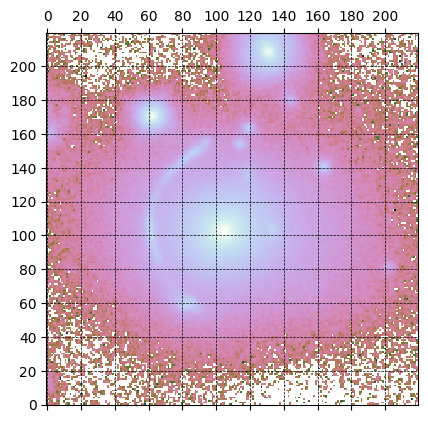

In [ ]:
plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.grid(True, which="both", linewidth=0.5, linestyle="--", color="black")

plt.xticks(np.arange(0, 220, 20))
plt.yticks(np.arange(0, 220, 20))

plt.show()

# Creating Likelihood Mask

A likelihood mask is a tool used in statistical analysis, particularly in Bayesian statistics, to identify data points that have a strong influence on the final results of a model. It is a binary mask that identifies which data points in the model contribute to the likelihood function, and which data points do not.

In practical terms, a likelihood mask can be created by setting a threshold for the quality of the data, such as the signal-to-noise ratio or the uncertainty in the measurements. Data points that do not meet this threshold can be masked out, effectively removing them from the analysis. This can help to improve the accuracy and precision of the model by reducing the impact of noisy or unreliable data.

Likelihood masks can also be used to exclude regions of the data that are known to be problematic, such as areas affected by foreground contamination, instrumental effects, or other sources of systematic error. By excluding these regions from the analysis, the likelihood mask can help to improve the robustness and reliability of the model.

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8.5  # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.8,
    lens_center_dec + 4.75,
    1.7,
    1.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.9,
    lens_center_dec + 8.0,
    2.8,
    2.8,
    0,
)

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.55,
    lens_center_dec + 5.2,
    0.6,
    0.6,
    0,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.3,
    lens_center_dec + 2.4,
    0.8,
    0.9,
    0,
)

mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 7.5,
    lens_center_dec - 2.5,
    0.6,
    0.6,
    0,
)

mask_ext_6 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec + 4,
    0.8,
    1,
    0,
)


mask_ext_7 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec + 1.9,
    0.8,
    0.9,
    0,
)

mask_ext_8 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.3,
    lens_center_dec - 3,
    1.5,
    2.2,
    np.pi / 12,
)

mask_ext_9 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 0.8,
    0.25,
    0.25,
    0,
)

"""
mask_ext_8 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+2.2,
                                   lens_center_dec-3.9,
                                   1.3, 1.1, np.pi/6)

mask_ext_9 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-1.8,
                                   lens_center_dec-0.5,
                                   .7, .7, 0)
"""
mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
    * (1 - mask_ext_5)
    * (1 - mask_ext_6)
    * (1 - mask_ext_7)
    * (1 - mask_ext_8)
    * (1 - mask_ext_9)
)
mask[mask < 0] = 0


mask_img_1 = mask.reshape(num_pix, num_pix)

# Applying the Mask

<ipython-input-8-14073cec0ced>:3: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(kwargs_data['image_data']),
<ipython-input-8-14073cec0ced>:16: RuntimeWarning: divide by zero encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)
<ipython-input-8-14073cec0ced>:16: RuntimeWarning: invalid value encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)


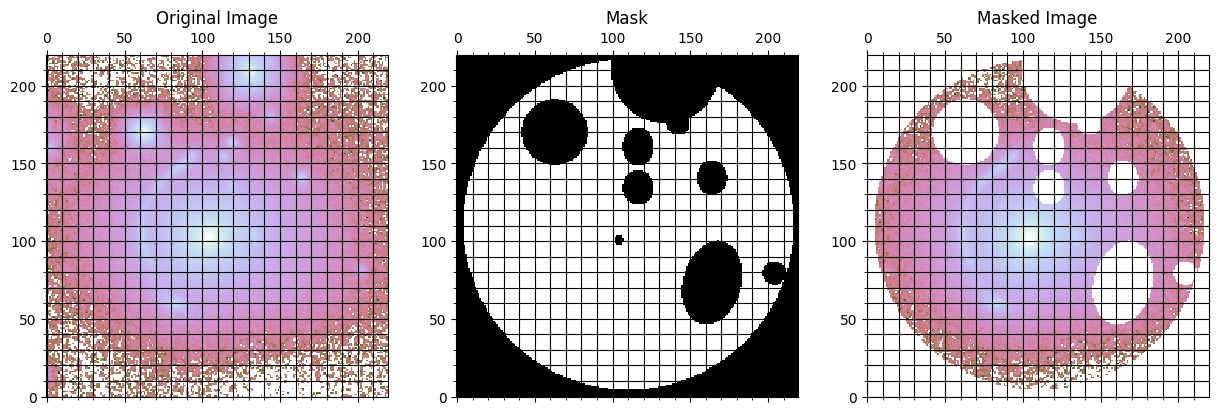

In [ ]:
# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
ax1.grid(which="both", color="black")
ax1.minorticks_on()
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(mask_img_1, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax2.title.set_text("Mask")

image1 = np.log10(kwargs_data["image_data"] * mask_img_1)

ax3.matshow(image1, origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.minorticks_on()
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens galaxy's mass model

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# 'EPL'
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 3.32635,
        "gamma": 1.81094,
        "e1": 0.11371,
        "e2": -0.07394,
        "center_x": 0.54844,
        "center_y": -0.5563,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.3,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# add external SHEAR
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": -0.06649, "gamma2": -0.05568})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


## Lens galaxy's light model

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# First Sersic profile
fixed_lens_light.append({"n_sersic": 1.0})  # SERSIC_ELLIPSE

kwargs_lens_light_init.append(
    {
        "R_sersic": 3.10360,
        "n_sersic": 1,
        "e1": 0.29018,
        "e2": 0.08729,
        "center_x": 0.4589,
        "center_y": -0.64499,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 9,
        "n_sersic": 1.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# Second Sersic profile
fixed_lens_light.append({"n_sersic": 4.0})  # SERSIC_ELLIPSE
kwargs_lens_light_init.append(
    {
        "R_sersic": 1.24007,
        "n_sersic": 4,
        "e1": 0.04798,
        "e2": -0.062085,
        "center_x": 0.45891,
        "center_y": -0.64499,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 4.0,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 4.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# Join centroids of the two Sersic profiles
# joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]


lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

## Source galaxy's light model

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

source_model_list += ["SHAPELETS"]

# source galaxy's light model
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init = [
    {
        "n_sersic": 1,
        "R_sersic": 0.3190,
        "e1": -0.18573,
        "e2": 0.01174,
        "center_x": 0.97804,
        "center_y": -0.37836,
        "amp": 16,
    }
]
kwargs_source_sigma = [
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
]
kwargs_lower_source = [
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
]
kwargs_upper_source = [
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
]

# SHAPELETS profile
fixed_source.append({"n_max": 10})
kwargs_source_init.append(
    {"beta": 0.07730, "center_x": 0.97804, "center_y": -0.38637, "n_max": 10}
)
kwargs_source_sigma.append({"beta": 0.5, "center_x": 0.2, "center_y": 0.2, "n_max": 10})
kwargs_lower_source.append(
    {"beta": 0.01, "center_x": -10, "center_y": -10, "n_max": 10}
)
kwargs_upper_source.append({"beta": 50, "center_x": 10, "center_y": 10, "n_max": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

## combining all the above specification in the `kwargs_params` dictionary

In [ ]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    #'joint_lens_with_light': joint_lens_with_light,
}

#### Numerical settings

Applied Mask Likelihood here

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img_1]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has independent
    # solutions of the surface brightness,
    # 'joint-linear': there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## Here the model fiting is done

In [16]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 500, "n_iterations": 100}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9832278015147456 reduced X^2 of best position
-14199.775909475957 log likelihood
28884 effective number of data points
[{'theta_E': 3.342327598018324, 'gamma': 1.79311025260998, 'e1': 0.11740065015569232, 'e2': -0.07423992021303961, 'center_x': 0.5428498327508385, 'center_y': -0.5526416194164764}, {'gamma1': -0.061311652328717464, 'gamma2': -0.05656938503218943, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.2749288436498359, 'n_sersic': 1.0, 'e1': -0.2031637436251894, 'e2': 0.03501657824855247, 'center_x': 0.9730707394557392, 'center_y': -0.4414777109057351}, {'amp': 1, 'n_max': 10, 'beta': 0.07658726608585911, 'center_x': 0.9730707394557392, 'center_y': -0.4414777109057351}] source result
[{'amp': 1, 'R_sersic': 3.0821878946649086, 'n_sersic': 1.0, 'e1': 0.2252679829324913, 'e2': 0.04788061575405723, 'center_x': 0.4548391865132354, 'center_y': -0.6510190172199614}, {'amp': 1, 'R_se

## Visualizing the fitted model

-0.9801398381424912 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9801398381424906


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


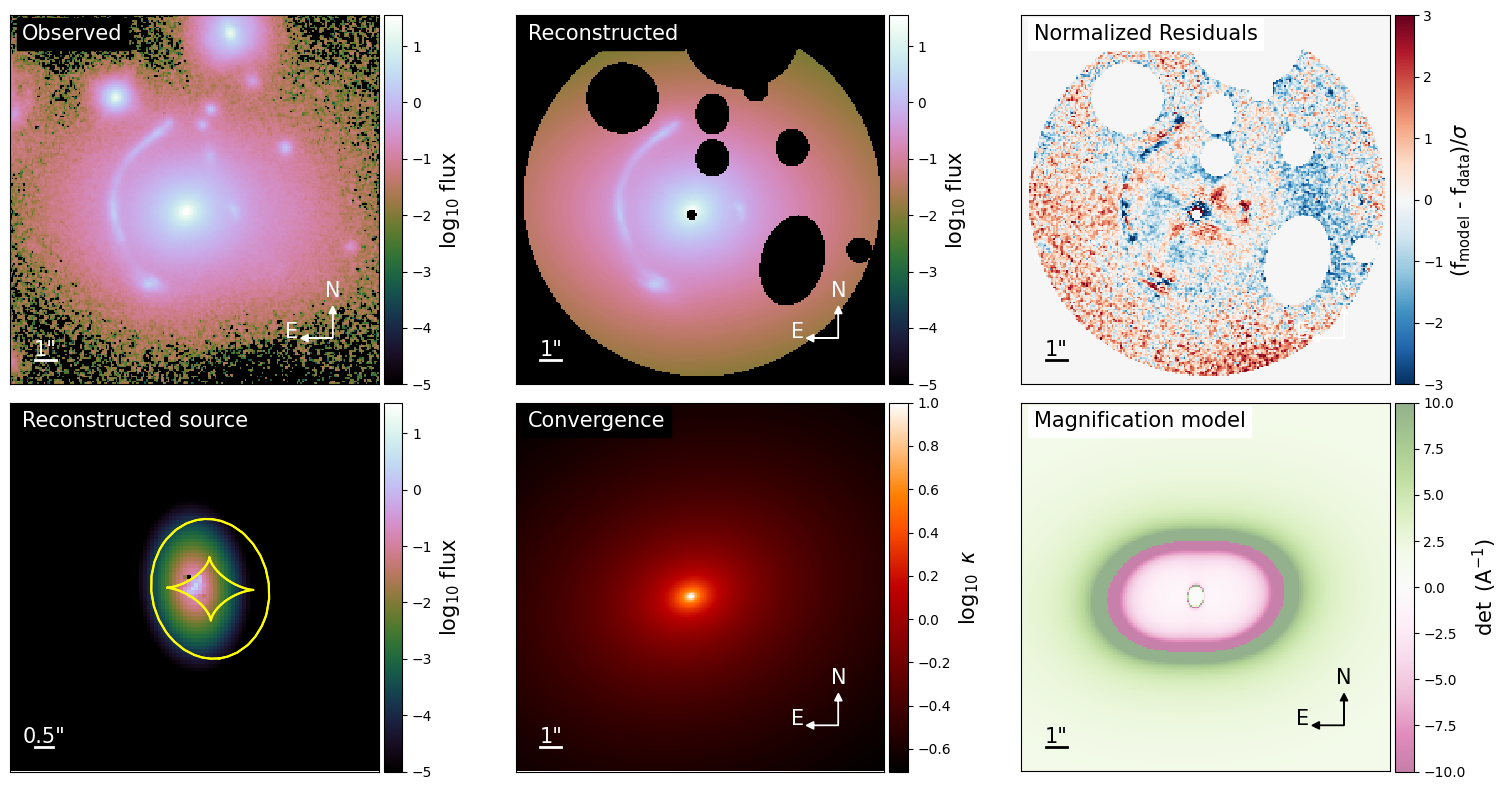

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


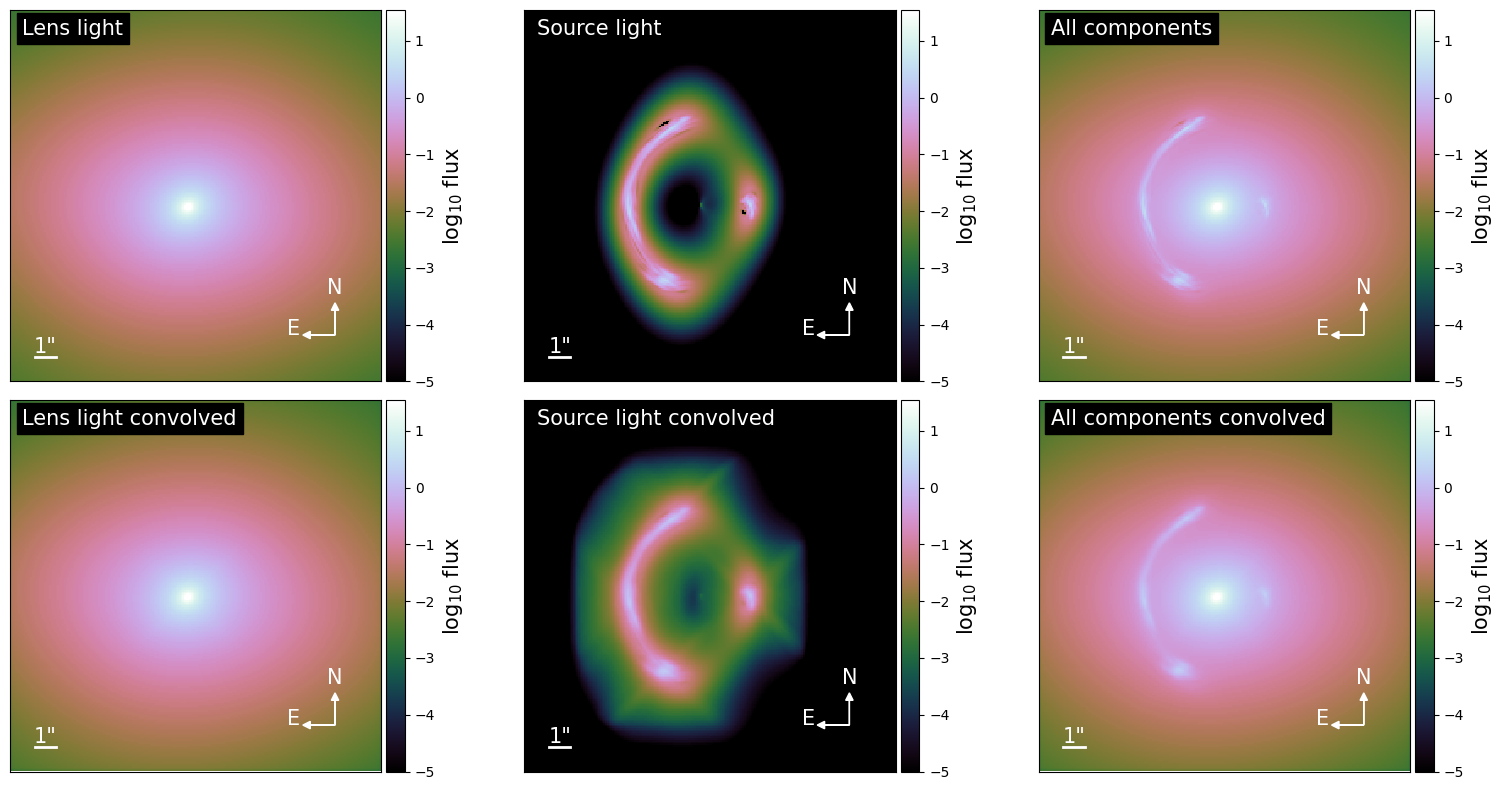

{'kwargs_lens': [{'theta_E': 3.342327598018324, 'gamma': 1.79311025260998, 'e1': 0.11740065015569232, 'e2': -0.07423992021303961, 'center_x': 0.5428498327508385, 'center_y': -0.5526416194164764}, {'gamma1': -0.061311652328717464, 'gamma2': -0.05656938503218943, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.2749288436498359, 'n_sersic': 1.0, 'e1': -0.2031637436251894, 'e2': 0.03501657824855247, 'center_x': 0.9730707394557392, 'center_y': -0.4414777109057351}, {'amp': 1, 'n_max': 10, 'beta': 0.07658726608585911, 'center_x': 0.9730707394557392, 'center_y': -0.4414777109057351}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 3.0821878946649086, 'n_sersic': 1.0, 'e1': 0.2252679829324913, 'e2': 0.04788061575405723, 'center_x': 0.4548391865132354, 'center_y': -0.6510190172199614}, {'amp': 1, 'R_sersic': 0.9273077938921095, 'n_sersic': 4.0, 'e1': 0.04228653106304903, 'e2': -0.06383483085606721, 'center_x': 0.4548391865132354, 'center_y': -0.6510190172199614}], 'kwargs_ps':

In [17]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.1, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result)

In [18]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ2158+0257_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)